## Figure 14

Similar to [Figure 11](https://github.com/EdwardJKim/astroclass/blob/master/paper/notebooks/figure11/purity_mag_cut.ipynb)
but as a function of $g-r$ color.

In [14]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
plt.rc('legend', fontsize=10)

In [15]:
truth_train = np.loadtxt('../../data/truth_train.dat')
truth_test = np.loadtxt('../../data/truth_test.dat')
mask_w1_train = np.loadtxt('../../data/vvds_w1_train.mask').astype(bool)
g_r_train = np.loadtxt('../../data/g_r.train.dat')
g_r_test = np.loadtxt('../../data/g_r.test.dat')

In [16]:
tpc_test = np.loadtxt('../../data/w1_22_0_tpc_test.mlz', unpack=True, usecols=(2,))
som_test = np.loadtxt('../../data/w1_22_0_som_test.mlz', unpack=True, usecols=(2,))
hbc_all = np.loadtxt('../../data/w1_22_0_median.hbc', unpack=True, usecols=(0,))
hbc_cv = hbc_all[:-len(truth_test)]
hbc_test = hbc_all[-len(truth_test):]
bmc_test = np.loadtxt('../../data/w1_22_0.bmc')

In [17]:
# read in FLUX_RADIUS and MAG_i and make a classification
def morph_class(magnitude, half_radius, cut=[0, 25, 1.0, 3.0]):
    point_source = ((magnitude > cut[0]) & (magnitude < cut[1]) &
                    (half_radius > cut[2]) & (half_radius < cut[3]))
    return point_source.astype(np.int)

mag_i_lower = 17
mag_i_upper = 21.0
r_h_lower = 1.4
r_h_upper = 2.8

r_h_test = np.loadtxt('../../data/flux_radius.test.dat')
mag_i_test = np.loadtxt('../../data/mag_i.test.dat')
morph_test = morph_class(mag_i_test, r_h_test, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

In [18]:
bins = np.arange(-0.75, 2.75, 0.05)

In [19]:
def find_purity_at(truth_test, clf, step=0.001, gc=None, gp=None, sc=None, sp=None):
    
    if bool(gc) and bool(sc) and bool(gp) and bool(sp):
        raise Exception('Specify only one of gp or sp parameter.')

    pbin = np.arange(0, 1, step)
    
    pure_all = np.zeros(len(pbin))
    comp_all = np.zeros(len(pbin))
    
    for i, p in enumerate(pbin):
        
        # true galaxies classified as stars
        gs = ((clf >= p) & (truth_test == 0)).sum()
        # true galaxies classified as galaxies
        gg = ((clf < p) & (truth_test == 0)).sum()
        # true stars classified as galaxies
        sg = ((clf < p) & (truth_test == 1)).sum()
        # true stars classified as stars
        ss = ((clf >= p) & (truth_test == 1)).sum()
    
        if gc is not None or gp is not None:
            if gg == 0 and sg == 0:
                pure_all[i] = np.nan
            else:
                pure_all[i] = gg / (gg + sg)
            if gg == 0 and gs == 0:
                comp_all[i] = np.nan
            else:
                comp_all[i] = gg / (gg + gs)
            
        if sc is not None or sp is not None:
            if ss == 0 and sg == 0:
                comp_all[i] = np.nan
            else:
                comp_all[i] = ss / (ss + sg)
            if ss == 0 and gs == 0:
                pure_all[i] = np.nan
            else:
                pure_all[i] = ss / (ss + gs)
    
    if gc is not None:
        ibin = np.argmin(np.abs(comp_all - gc))
        return pbin[ibin], pure_all[ibin]
    
    if gp is not None:
        ibin = np.argmin(np.abs(pure_all - gp))
        return pbin[ibin], comp_all[ibin]
    
    if sc is not None:
        ibin = np.argmin(np.abs(comp_all - sc))
        return pbin[ibin], pure_all[ibin]
    
    if sp is not None:
        ibin = np.argmin(np.abs(pure_all - sp))
        return pbin[ibin], comp_all[ibin]

In [20]:
def find_gal_pur(mag_i_test, bmc_test, truth_test, p_cut=0.5, bandwidth=0.1):
    # all objects classified as galaxies
    xg = mag_i_test[(bmc_test < p_cut)]
    bandwidth = 1.06 * np.std(xg[(xg > -99) & (xg < 99)]) * np.power(len(xg), -0.2)
    kde_xg = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(xg[:, np.newaxis])
    log_dens_xg = kde_xg.score_samples(x_kde)

    # true galaxies classified as galaxies
    gg = mag_i_test[(bmc_test < p_cut) & (truth_test == 0)]
    #bandwidth = 1.06 * np.std(gg[(gg > -99) & (gg < 99)]) * np.power(len(gg), -0.2)
    kde_gg = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(gg[:, np.newaxis])
    log_dens_gg = kde_gg.score_samples(x_kde)

    g_pur = len(gg) * np.exp(log_dens_gg) / np.exp(log_dens_gg).sum() \
        / (len(xg) * np.exp(log_dens_xg) / np.exp(log_dens_xg).sum())
    
    return g_pur

def find_star_pur(mag_i_test, bmc_test, truth_test, p_cut=0.5, bandwidth=0.1):
    # all objects classified as stars
    xs = mag_i_test[(bmc_test >= p_cut)]
    bandwidth = 1.06 * np.std(xs[(xs > -99) & (xs < 99)]) * np.power(len(xs), -0.2)
    kde_xs = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(xs[:, np.newaxis])
    log_dens_xs = kde_xs.score_samples(x_kde)

    # true stars classified as stars
    ss = mag_i_test[(bmc_test >= p_cut) & (truth_test == 1)]
    #bandwidth = 1.06 * np.std(ss[(ss > -99) & (ss < 99)]) * np.power(len(ss), -0.2)
    kde_ss = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(ss[:, np.newaxis])
    log_dens_ss = kde_ss.score_samples(x_kde)

    s_pur = len(ss) * np.exp(log_dens_ss) / np.exp(log_dens_ss).sum() \
        / (len(xs) * np.exp(log_dens_xs) / np.exp(log_dens_xs).sum())
    
    return s_pur

In [21]:
def find_star_frac(mag_i_test, clf_test, truth_test, p_cut=0.5, bandwidth=0.1):

    # total objects
    xx = mag_i_test
    bandwidth = 1.06 * np.std(xx[(xx > -99) & (xx < 99)]) * np.power(len(xx), -0.2)
    kde_xx = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(xx[:, np.newaxis])
    log_dens_xx = kde_xx.score_samples(x_kde)

    # all true stars
    sx = mag_i_test[truth_test == 1]
    #bandwidth = 1.06 * np.std(sx[(sx > -99) & (sx < 99)]) * np.power(len(sx), -0.2)
    kde_sx = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sx[:, np.newaxis])
    log_dens_sx = kde_sx.score_samples(x_kde)

    s_frac = len(sx) * np.exp(log_dens_sx) / np.exp(log_dens_sx).sum() \
        / (len(xx) * np.exp(log_dens_xx) / np.exp(log_dens_xx).sum())
    
    return s_frac

In [22]:
def find_conf(func, mag_i_test, bmc_test, truth_test, p_cut=0.5, n_boots=100):
    
    s_pur_boots = [func(mag_i_test, bmc_test, truth_test, p_cut=p_cut)]
    
    print("Bootstrapping...")
    
    for i in range(1, n_boots):
        rows = np.floor(np.random.rand(len(truth_test)) * len(truth_test)).astype(int)
        mag_i_test_boots = mag_i_test[rows]
        bmc_test_boots = bmc_test[rows]
        truth_test_boots = truth_test[rows]
        s_pur_boots.append(func(mag_i_test_boots, bmc_test_boots, truth_test_boots, p_cut=p_cut))
        
        if i % (n_boots / 10) == 0:
            print("{0:.0f} percent complete...".format(i / n_boots * 100))
    
    s_pur_lower = np.percentile(s_pur_boots, 0.16, axis=0)
    s_pur_med = np.percentile(s_pur_boots, 0.50, axis=0)
    s_pur_upper = np.percentile(s_pur_boots, 0.84, axis=0)
    
    print("Complete.")
    
    return s_pur_med, s_pur_lower, s_pur_upper

In [23]:
n_boots = 1000

In [24]:
x_kde = bins[:, np.newaxis]

# W1
# Silverman's rule of thumb
w1 = g_r_train[mask_w1_train]
bandwidth = 1.06 * np.std(w1) * np.power(len(w1), -0.2)
kde_g_r_w1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(w1[:, np.newaxis])
log_dens_g_r_w1 = kde_g_r_w1.score_samples(x_kde)

# test
bandwidth = 1.06 * np.std(g_r_test) * np.power(len(g_r_test), -0.2)
kde_g_r_test = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(g_r_test[:, np.newaxis])
log_dens_g_r_test = kde_g_r_test.score_samples(x_kde)

In [37]:
stars_frac_w1_med, stars_frac_w1_lower, stars_frac_w1_upper = find_conf(
    find_star_frac, g_r_train[mask_w1_train], truth_train[mask_w1_train], truth_train[mask_w1_train], n_boots=n_boots)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [38]:
stars_frac_test_med, stars_frac_test_lower, stars_frac_test_upper = find_conf(
    find_star_frac, g_r_test, truth_test, truth_test, n_boots=n_boots)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [27]:
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, gc=0.9964, step=0.0001)

bmc_g_pur_med, bmc_g_pur_lower, bmc_g_pur_upper = find_conf(
    find_gal_pur, g_r_test, bmc_test, truth_test, p_cut=bmc_p_cut, n_boots=n_boots)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [28]:
tpc_p_cut, _ = find_purity_at(truth_test, tpc_test, gc=0.9964, step=0.0001)

tpc_g_pur_med, tpc_g_pur_lower, tpc_g_pur_upper = find_conf(
    find_gal_pur, g_r_test, tpc_test, truth_test, p_cut=tpc_p_cut, n_boots=n_boots)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [29]:
morph_g_pur_med, morph_g_pur_lower, morph_g_pur_upper = find_conf(
    find_gal_pur, g_r_test, morph_test, truth_test, p_cut=0.5, n_boots=n_boots)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [30]:
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, sc=0.7145, step=0.0001)

bmc_s_pur_med, bmc_s_pur_lower, bmc_s_pur_upper = find_conf(
    find_star_pur, g_r_test, bmc_test, truth_test, p_cut=bmc_p_cut, n_boots=n_boots)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [31]:
tpc_p_cut, _ = find_purity_at(truth_test, bmc_test, sc=0.7145, step=0.0001)

tpc_s_pur_med, tpc_s_pur_lower, tpc_s_pur_upper = find_conf(
    find_star_pur, g_r_test, tpc_test, truth_test, p_cut=tpc_p_cut, n_boots=n_boots)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [32]:
morph_s_pur_med, morph_s_pur_lower, morph_s_pur_upper = find_conf(
    find_star_pur, g_r_test, morph_test, truth_test, p_cut=0.5, n_boots=n_boots)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


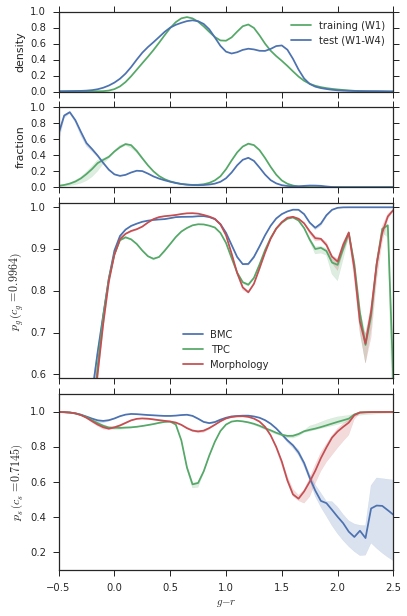

In [39]:
p = sns.color_palette()
sns.set_style("ticks")

alpha = 0.2

fig = plt.figure(figsize=(6, 10))

ax0 = plt.subplot2grid((6, 3), (0, 0), colspan=3)
ax1 = plt.subplot2grid((6, 3), (1, 0), colspan=3)
ax2 = plt.subplot2grid((6, 3), (2, 0), colspan=3, rowspan=2)
ax3 = plt.subplot2grid((6, 3), (4, 0), colspan=3, rowspan=2)

plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

#ax0.hist(g_r_test[mask_w1_test], bins=bins, histtype='bar', color=p[0], alpha=alpha)
ax0.plot(x_kde[:, 0], np.exp(log_dens_g_r_w1), label='training (W1)', color=p[1])

#ax0.hist(g_r_test, bins=bins, histtype='bar', color=p[1], alpha=alpha)
ax0.plot(x_kde[:, 0], np.exp(log_dens_g_r_test), label='test (W1-W4)', color=p[0])

ax0.set_xlim(-0.5, 2.5)
#ax0.set_yticks([0, 40, 80, 120, 160])
ax0.set_ylabel('density')
ax0.legend(loc='upper right')

ax1.plot(x_kde[:, 0], stars_frac_w1_med, label='W1', color=p[1])
ax1.fill_between(x_kde[:, 0], stars_frac_w1_lower, stars_frac_w1_upper, color=p[1], alpha=0.2)

ax1.plot(x_kde[:, 0], stars_frac_test_med, label='W4', color=p[0])
ax1.fill_between(x_kde[:, 0], stars_frac_test_lower, stars_frac_test_upper, color=p[0], alpha=0.2)

ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(0, 1)
ax1.set_ylabel('fraction')

ax2.plot(x_kde[:, 0], bmc_g_pur_med, label='BMC', ls='-', color=p[0])
ax2.fill_between(x_kde[:, 0], bmc_g_pur_lower, bmc_g_pur_upper, color=p[0], alpha=alpha)

ax2.plot(x_kde[:, 0], tpc_g_pur_med, label='TPC', ls='-', color=p[1])
ax2.fill_between(x_kde[:, 0], tpc_g_pur_lower, tpc_g_pur_upper, color=p[1], alpha=alpha)

ax2.errorbar(x_kde[:, 0], morph_g_pur_med, label='Morphology', ls='-', color=p[2])
ax2.fill_between(x_kde[:, 0], morph_g_pur_lower, morph_g_pur_upper, color=p[2], alpha=alpha)
ax2.set_xlim(-0.5, 2.5)
ax2.set_ylim(0.59, 1.01)
ax2.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
ax2.legend(loc='lower center')

##ax2.set_yticks([0.9, 0.95, 1.0])
ax2.set_ylabel(r'$p_g\left(c_g=0.9964\right)$', fontsize=12)

ax3.plot(x_kde[:, 0], bmc_s_pur_med, label='BMC', ls='-', c=p[0])
ax3.fill_between(x_kde[:, 0], bmc_s_pur_lower, bmc_s_pur_upper, color=p[0], alpha=alpha)

ax3.plot(x_kde[:, 0], tpc_s_pur_med, label='TPC', ls='-', c=p[1])
ax3.fill_between(x_kde[:, 0], tpc_s_pur_lower, tpc_s_pur_upper, color=p[1], alpha=alpha)

ax3.plot(x_kde[:, 0], morph_s_pur_med, label='Morphology', ls='-', c=p[2])
ax3.fill_between(x_kde[:, 0], morph_s_pur_lower, morph_s_pur_upper, color=p[2], alpha=alpha)
ax3.set_ylabel(r'$p_s\left(c_s=0.7145\right)$', fontsize=12)
ax3.set_xlim(-0.5, 2.5)
ax3.set_ylim(0.1, 1.1)
#ax3.set_yticks([0.88, 0.92, 0.96, 1.00])
ax3.set_xlabel(r'$g-r$')

plt.savefig('../../figures/purity_g_r_cut.pdf')

plt.show()